In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from keras.models import load_model
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from nn_util import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE,))

X_train = np.copy(train_processed)

In [5]:
MODEL_FILENAME = './best_coder.h5'

KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization}

autoencoder = load_model(MODEL_FILENAME, KERAS_LOAD_MAP)
K.set_value(QUANTIZATION_ON, True)

/usr/local/lib/python2.7/dist-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [7]:
pre_quant = Model(inputs = encoder.get_input_at(0),
                  outputs = encoder.layers[-1].input)

post_dequant = Model(inputs = decoder.get_input_at(0),
                     outputs = decoder.layers[1].output)

# Analysis

In [8]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 4s     


## Symbol histograms / entropy

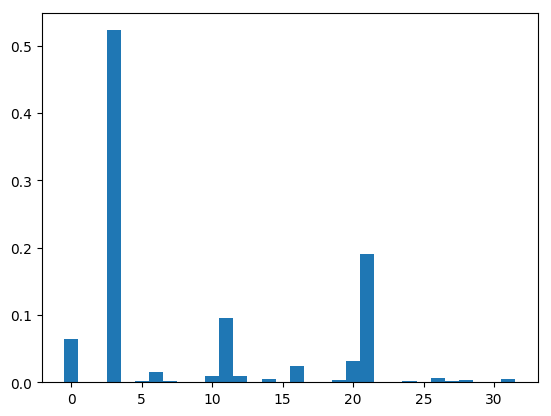

Entropy of distribution: 2.32870429595
[  6.44007027e-02   7.36909686e-04   1.59954841e-04   5.22690535e-01
   4.53439279e-04   1.81830768e-03   1.56762321e-02   2.38075131e-03
   2.27444561e-05   8.14030136e-05   9.81455762e-03   9.60877985e-02
   9.60955024e-03   1.54253037e-04   5.04892832e-03   8.73921032e-04
   2.47618780e-02   4.14677314e-04   1.40791846e-04   3.10656521e-03
   3.11296601e-02   1.91086963e-01   2.72309971e-05   1.45731654e-04
   1.82038767e-03   9.10793606e-05   6.78254850e-03   1.39308313e-03
   3.83597240e-03   1.06388004e-03   1.94202385e-05   4.17016726e-03]
Bins:
[ 0.90525776 -1.93810248  2.78330946  0.17848431  2.39581013 -1.39154124
 -0.4613601  -1.24249113  2.60047817  3.52461195  1.48058963 -0.16563907
 -0.58757252  2.54550743 -0.83404303  2.19486141  1.20394444 -2.21528077
  3.0304966  -1.09769046 -0.32411951  0.59240562  2.57051921 -2.59579158
  1.98350644  2.62633348 -0.70878029 -1.5452075  -0.96314234 -1.72352719
  2.5854044   1.74366665]


In [9]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-5): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print hist
print "Bins:"
print K.eval(QUANT_BINS)

In [10]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave)

embed = encoder.predict(windows, batch_size = BATCH_SIZE, verbose = 1)
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

before_quantization = pre_quant.predict(windows, batch_size = BATCH_SIZE, verbose = 1)
after_dequantization = post_dequant.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


Original


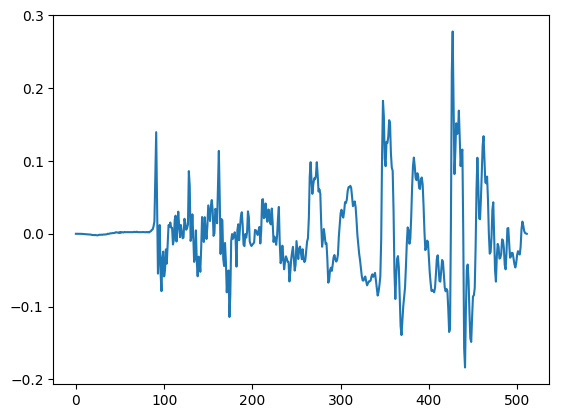

Reconstruction


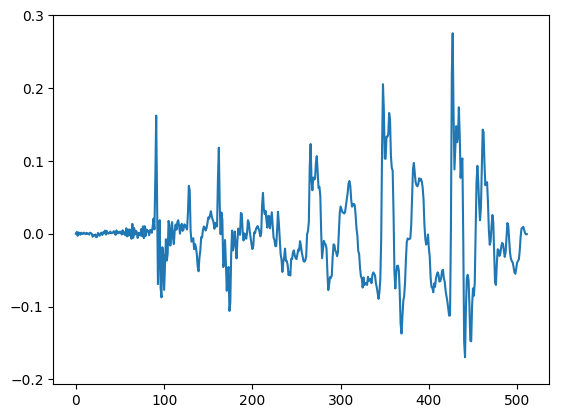

Before quantization


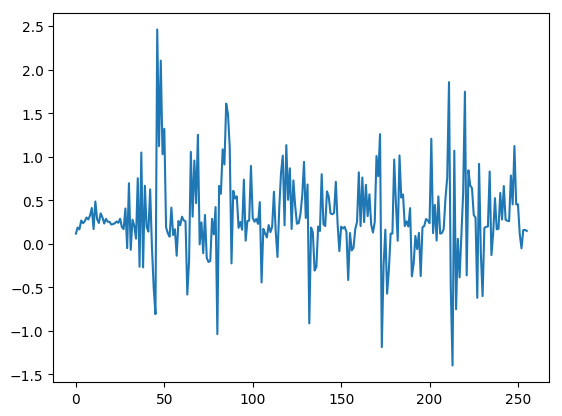

After dequantization


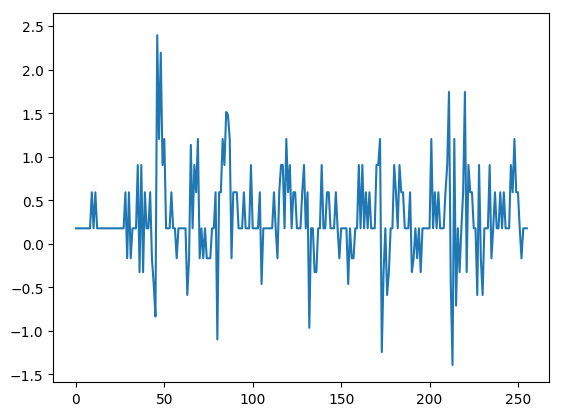

Error


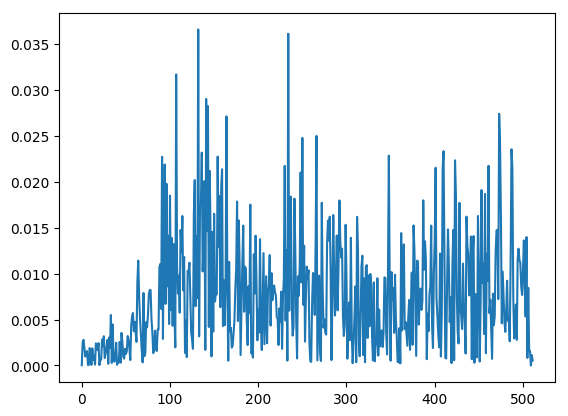

In [11]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Before quantization"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

    print "After dequantization"
    plt.plot(after_dequantization[idx])
    plt.ylim(ylim)
    plt.show()
else:
    print "Embedding"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

print "Error"
plt.plot(abs(orig - recn))
plt.show()